# Reconocimiento de dígitos con KNN, con y sin weights


Definir los path al ejecutable de python 3.6 y sus librerías,
de acuerdo al virtual env que estén corriendo.

In [ ]:
!cd .. && ./build.sh

## Explorando los datos

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd

df_train = pd.read_csv("../data/train.csv")
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


### Reducir el dataset

Ya que el dataset es grande, me quedo con una porción de éste

**<font color=red>ESTO ES SOLO PARA HACER PRUEBAS. CUANDO REPORTEN LOS RESULTADOS, USAR DATASET COMPLETO</font>**

In [ ]:
df_train.sample(frac=1)
df_train = df_train[:5000]
df_train.info()

In [2]:
# Uso values para mandar todo a arrays de numpy
X = df_train[df_train.columns[1:]].values
y = df_train["label"].values.reshape(-1, 1)

X.shape, y.shape

((42000, 784), (42000, 1))

### Conjunto de development

In [ ]:
import metnum
import pandas as pd

from scoring import metrics
from scoring import cross_validation as cv
from tqdm import tqdm

scoring_fns = {
    "accuracy":  metrics.accuracy_score,
    "recall":    metrics.recall_score,
    "precision": metrics.precision_score,
    "f1":        metrics.f1_score,
}

ks = [1, 2, 4, 6, 8, 10, 20, 30, 40, 60, 80, 100]#, 150, 200, 250, 300, 400, 500, 600, 800, 1000]

rows = []

for k in tqdm(ks):
    clf = metnum.KNNClassifier(k)
    for weight_type in ["uniform", "distance", "distance_pow"]:
        scores = cv.cross_validate_fns(clf, X, y, scoring_fns, 4, weights=weight_type)

        # scores es un dict con las keys de scoring_fns, que son las
        # mismas que las columnas del dataframe.
        rows.append({
            **{
                "k": k,
                "weight_type": weight_type,
            }, 
            **scores
        })

print("Creating DataFrame...")
df = pd.DataFrame(rows, columns=["k", "weight_type", "accuracy", "recall", "precision", "f1"])

print("Finished!")

In [3]:
# Concurrent
import metnum
import pandas as pd

from scoring import metrics
from scoring import cross_validation as cv
from tqdm import tqdm
import concurrent.futures

# Scorings a calcular
scoring_fns = {
    "accuracy":  metrics.accuracy_score,
    "recall":    metrics.recall_score,
    "precision": metrics.precision_score,
    "f1":        metrics.f1_score,
}

# Cantidad de folds
K_FOLD = 6

# ks de kNN a probar
#ks = [1, 2, 4, 6, 8, 10, 20, 30, 40, 60, 80, 100]#, 150, 200, 250, 300, 400, 500, 600, 800, 1000]
ks = [1, 2, 4, 6, 8, 10]

def run_classifier(k: int):
    clf = metnum.KNNClassifier(k)
    clf_rows = []
    for weight_type in ["uniform", "distance_pow"]:
        print("k: {}, weight: {} start".format(k, weight_type))
        scores = cv.cross_validate_fns(clf, X, y, scoring_fns, K_FOLD, weights=weight_type)

        # scores es un dict con las keys de scoring_fns, que son las
        # mismas que las columnas del dataframe.
        clf_rows.append({
            **{
                "k": k,
                "weight_type": weight_type,
            }, 
            **scores
        })
        print("k: {}, weight: {} end".format(k, weight_type))
    
    return clf_rows

# Ejemplo de ThreadPoolExecutor sacado de:
# https://docs.python.org/3/library/concurrent.futures.html#threadpoolexecutor-example
rows = []
with concurrent.futures.ThreadPoolExecutor(max_workers=3) as executor:
    futures = [executor.submit(run_classifier, k) for k in tqdm(ks, "futures")]
    for future in tqdm(concurrent.futures.as_completed(futures), "completed futures"):
        rows.extend(future.result())

print("Creating DF")
df = pd.DataFrame(rows, columns=["k", "weight_type", "accuracy", "recall", "precision", "f1"])

print("Finished!")

futures: 100%|██████████| 6/6 [00:00<00:00, 503.87it/s]
completed futures: 0it [00:00, ?it/s]

k: 1, weight: uniform start
k: 2, weight: uniform start
k: 4, weight: uniform start
k: 4, weight: uniform end
k: 4, weight: distance_pow start
k: 2, weight: uniform end
k: 2, weight: distance_pow start
k: 1, weight: uniform end
k: 1, weight: distance_pow start


completed futures: 1it [1:40:09, 6009.47s/it]

k: 4, weight: distance_pow end
k: 6, weight: uniform start


completed futures: 2it [1:52:52, 4435.48s/it]

k: 2, weight: distance_pow end
k: 8, weight: uniform start


completed futures: 3it [1:56:02, 3161.77s/it]

k: 1, weight: distance_pow end
k: 10, weight: uniform start
k: 6, weight: uniform end
k: 6, weight: distance_pow start
k: 8, weight: uniform end
k: 8, weight: distance_pow start
k: 10, weight: uniform end
k: 10, weight: distance_pow start


completed futures: 4it [3:35:13, 3998.71s/it]

k: 6, weight: distance_pow end
k: 8, weight: distance_pow end


completed futures: 6it [3:47:54, 2279.00s/it]

k: 10, weight: distance_pow end
Creating DF
Finished!


In [5]:
df.sort_values("accuracy", ascending=False)

,k,weight_type,accuracy,recall,precision,f1
1,4,distance_pow,0.970667,0.970250,0.971025,0.970499
7,6,distance_pow,0.970119,0.969655,0.970618,0.969976
9,8,distance_pow,0.969738,0.969259,0.970330,0.969611
11,10,distance_pow,0.969095,0.968645,0.969802,0.969018
3,2,distance_pow,0.966881,0.966425,0.967112,0.966641
4,1,uniform,0.966881,0.966425,0.967112,0.966641
5,1,distance_pow,0.966881,0.966425,0.967112,0.966641
0,4,uniform,0.965929,0.965355,0.966506,0.965686
6,6,uniform,0.965452,0.964868,0.966241,0.965285
8,8,uniform,0.964595,0.964026,0.965479,0.964468


(0.945, 0.98)

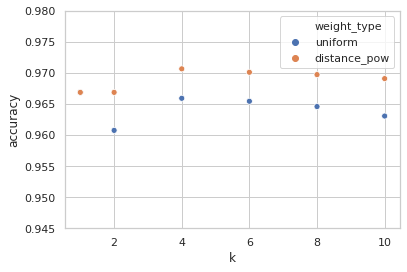

In [9]:
import seaborn as sns
sns.set(style="whitegrid")
plot = sns.scatterplot(
    data=df, x="k", y="accuracy", 
    hue="weight_type",
    legend="full",
)
plot.set_ylim(0.945, 0.98)

In [4]:
df.to_csv("K_6_knn_weights_per_k_concurrent.csv", index=False)

In [ ]:
## concluimos que distance_pow es el mejor
## TODO: graficar cosas